<a href="https://colab.research.google.com/github/sagar-rathod/PytorchDeepML/blob/master/examples/Multiclass_Scene_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the challenge data

In [ ]:
!pip install aicrowd-cli==0.1.10
%load_ext aicrowd.magic

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/vtdxpC4dkm1IpQk07FFJ-y_WC8CXwm2wAxlq-_Q4ASs
API Key valid
Saved API Key successfully!


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c scene-segmentation -o data

test.zip:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/166M [00:00<?, ?B/s]

Extract dataset

In [ ]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

Install deepml

In [ ]:
!pip install deepml

  Cloning https://github.com/sagar-rathod/deep-ml.git (to revision feature/multi_predictor) to /tmp/pip-req-build-p3es3b5z
  Running command git clone -q https://github.com/sagar-rathod/deep-ml.git /tmp/pip-req-build-p3es3b5z
  Running command git checkout -b feature/multi_predictor --track origin/feature/multi_predictor
  Switched to a new branch 'feature/multi_predictor'
  Branch 'feature/multi_predictor' set up to track remote branch 'feature/multi_predictor' from 'origin'.
  Created wheel for deepml: filename=deepml-2.0.0.dev0-py3-none-any.whl size=143543 sha256=fbfeb1861a67d3321a096785dc06c033938784935ad27856579183b08e3ce53a
  Stored in directory: /tmp/pip-ephem-wheel-cache-nppyv_nd/wheels/3c/18/10/28c909d83ef9eed9b81e388fea191a3515864eb0e062b61013
Successfully built deepml


Install [Segmentation Pytorch Model](https://github.com/qubvel/segmentation_models.pytorch) python. It contains ready to use pretrained model for segmentation.

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-0l3ip6sh
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-0l3ip6sh
     |████████████████████████████████| 58 kB 5.8 MB/s 
     |████████████████████████████████| 376 kB 36.8 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88601 sha256=f4b11b6326c02ed9c6427913f386f720f18bc70a36f31a86c727a6ffb7e3ff4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-285v_2k8/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=839e5e4405fa1a341c8a13cbedfde24ee3e6756562331828a713197c40eba273
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-n

Install Data Augmentation Library

In [ ]:
!pip install --upgrade --force-reinstall --no-deps albumentations==1.0.3

     |████████████████████████████████| 98 kB 7.0 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Install [monai](https://monai.io/). A PyTorch-based framework for deep learning in healthcare imaging. It contains state of the art collection of loss functions for segmentation.

In [ ]:
!pip install monai

     |████████████████████████████████| 650 kB 16.4 MB/s 


# Import packages

In [ ]:
# Pytorch 
import os
import numpy as np
import pandas as pd
import numpy as np

Visualize some random sample of input images.

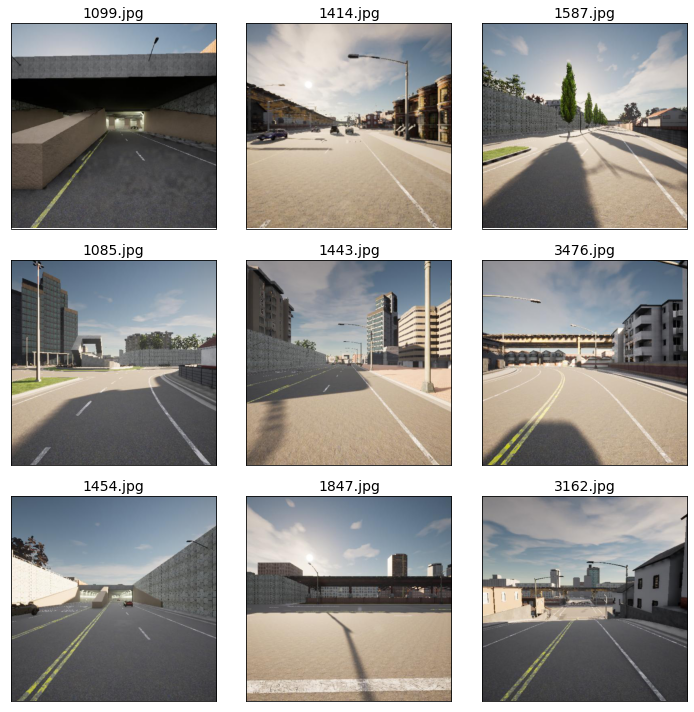

In [ ]:
from deepml.visualize import show_images_from_folder

show_images_from_folder("./data/train/image")

Visualize some random sample of target mask images.

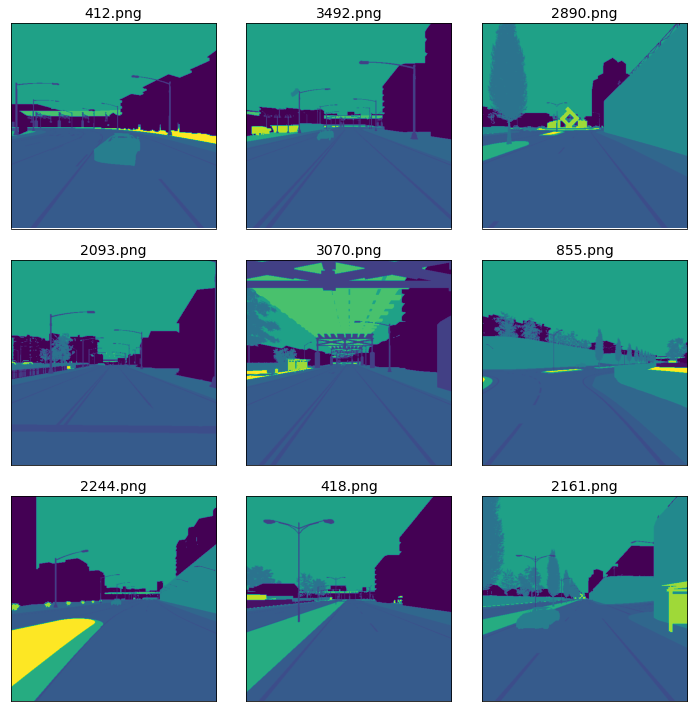

In [ ]:
from deepml.visualize import show_images_from_folder

show_images_from_folder("./data/train/segmentation")

Create input data frame containing image and mask columns

In [ ]:
train_dir = "./data/train"
train_images = os.listdir(os.path.join(train_dir, 'image'))
train_masks = [f"{os.path.splitext(i)[0]}.png" for i in train_images]

data_df = pd.DataFrame({"image": train_images, 'mask': train_masks})
data_df.head()

image      mask
0  1288.jpg  1288.png
1  2713.jpg  2713.png
2  1032.jpg  1032.png
3  3143.jpg  3143.png
4  1666.jpg  1666.png

In [ ]:
data_df.shape

(4000, 2)

Split the input dataframe into train and validation set.

In [ ]:
from sklearn.model_selection import train_test_split

seed = 49
train_df, val_df = train_test_split(data_df, train_size=0.975, random_state=seed)
train_df.shape, val_df.shape

((3900, 2), (100, 2))

Create data augmentation with imagenet preprocessing. We will use pretrained model on imagenet dataset.

In [ ]:
from deepml import constants
import albumentations as aug
from albumentations.pytorch.transforms import ToTensorV2

train_transforms = aug.Compose([ 
                                 aug.HorizontalFlip(p=0.5),
                                 aug.VerticalFlip(p=0.5),
                                 aug.RandomRotate90(p=0.5),
                                 aug.ShiftScaleRotate(p=0.5),
                                 aug.Normalize(mean=constants.IMAGENET_MEAN, std=constants.IMAGENET_STD),
                                 ToTensorV2(transpose_mask=False),
                                  ])

val_transforms = aug.Compose([
                              aug.Normalize(mean=constants.IMAGENET_MEAN, std=constants.IMAGENET_STD),
                              ToTensorV2(transpose_mask=False),
                            ])


Define torch dataset and data loaders

In [ ]:
from deepml.datasets import SegmentationDataFrameDataset
from deepml.transforms import MulticlassSegmentationTargetTransform

num_classes = 23
target_preprocess_transform = MulticlassSegmentationTargetTransform(num_classes=num_classes)

train_dataset = SegmentationDataFrameDataset(train_df, image_dir="./data/train/image", mask_dir="./data/train/segmentation", mask_col='mask',
                                             albu_torch_transforms=train_transforms, target_transform=target_preprocess_transform)

val_dataset = SegmentationDataFrameDataset(val_df, image_dir="./data/train/image", mask_dir="./data/train/segmentation", mask_col='mask',
                                             albu_torch_transforms=val_transforms, target_transform=target_preprocess_transform)

In [ ]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

Create model directory

In [ ]:
model_dir = "unet"
os.makedirs(model_dir, exist_ok=True)

Run tensorboard on colab (optional)

In [ ]:
# # Enable Tensorboard on colab
# %reload_ext tensorboard

# # Run tensorboard and provide model working directory
# %tensorboard --logdir 'deep_lab'

Choose Model Architecture

In [ ]:
import segmentation_models_pytorch as smp

unet = smp.UnetPlusPlus(encoder_name="efficientnet-b6", encoder_weights="imagenet",
                classes=num_classes)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Define Segmentation Task

In [ ]:
from deepml.tasks import Segmentation

segmentation_task = Segmentation(unet, model_dir=model_dir, load_saved_model=False, num_classes=num_classes)

Define Loss function

In [ ]:
import monai

criterion = monai.losses.DiceFocalLoss(softmax=True, batch=True, jaccard=True)

Metrics

In [ ]:
metrics = [
    ( "iou", smp.utils.metrics.IoU()),
    ( "fscore", smp.utils.metrics.Fscore()),
    ( "acc", smp.utils.metrics.Accuracy()),
    ("recall", smp.utils.metrics.Recall()),
    ("precision", smp.utils.metrics.Precision()),
]

Choose Optimizer & lr scheduler

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)
lr_scheduler = ReduceLROnPlateau(optimizer, patience=2)

Create instance of Learner class for training

In [ ]:
from deepml.train import Learner

learner = Learner(segmentation_task, optimizer, criterion)

Sanity check for validation loss:

In [ ]:
learner.validate(val_loader, criterion=criterion, metrics=metrics)

Validation  :   0%|          | 0/25 [00:00<?, ?it/s]

OrderedDict([('loss', 1.6963154554367066),
             ('iou', 0.024185467064380645),
             ('fscore', 0.04716417245566846),
             ('acc', 0.707017891407013),
             ('recall', 0.16678791046142577),
             ('precision', 0.02746551111340523)])

Start training

In [ ]:
from deepml.transforms import ImageNetInverseTransform

epochs = 5
learner.fit(train_loader, val_loader, epochs=epochs, lr_scheduler=lr_scheduler, image_inverse_transform=ImageNetInverseTransform(),
            metrics=metrics, save_model_after_every_epoch=15)

Epoch 1/30:


Training    :   0%|          | 0/975 [00:00<?, ?it/s]

Validation  :   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.7315 Validation Loss: 0.6192 [Saving best validation model]
Epoch 2/30:


Training    :   0%|          | 0/975 [00:00<?, ?it/s]

Validation  :   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.6196 Validation Loss: 0.5674 [Saving best validation model]
Epoch 3/30:


Training    :   0%|          | 0/975 [00:00<?, ?it/s]

Validation  :   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.5823 Validation Loss: 0.5449 [Saving best validation model]
Epoch 4/30:


Training    :   0%|          | 0/975 [00:00<?, ?it/s]

Validation  :   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.5645 Validation Loss: 0.5376 [Saving best validation model]
Epoch 5/30:


Training    :   0%|          | 0/975 [00:00<?, ?it/s]

Validation  :   0%|          | 0/25 [00:00<?, ?it/s]

Training Loss: 0.5499 Validation Loss: 0.5210 [Saving best validation model]
Epoch 6/30:


Training    :   0%|          | 0/975 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Visualize some sample prediction

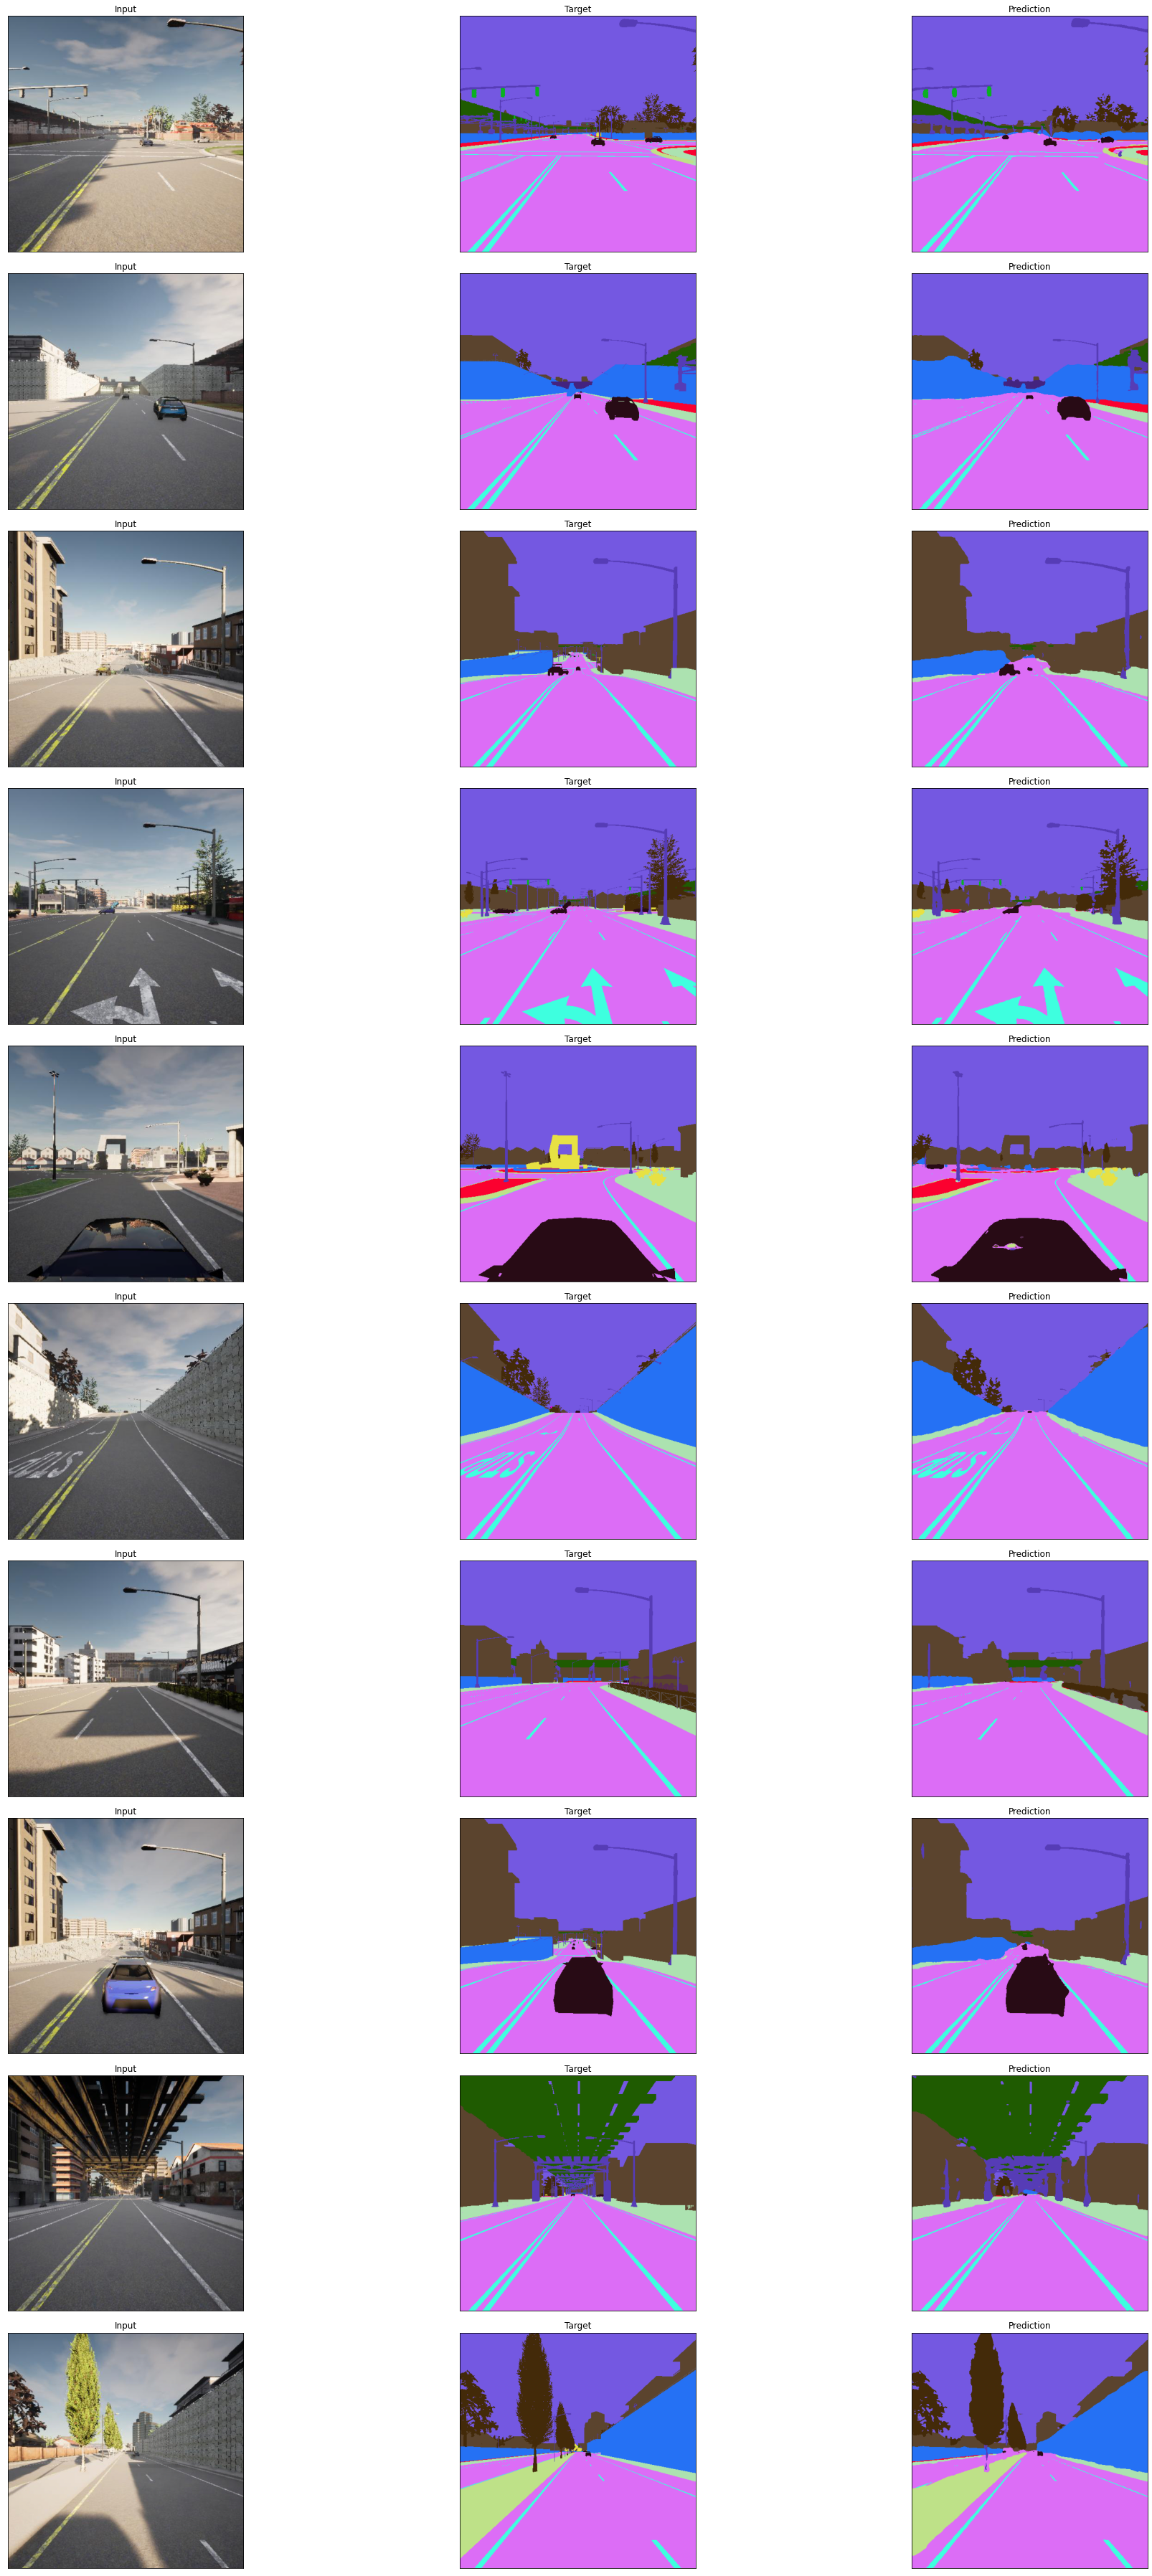

In [ ]:
from deepml.transforms import ImageNetInverseTransform

segmentation_task.show_predictions(val_loader, image_inverse_transform=ImageNetInverseTransform(), samples=10, 
                                    figsize=(30,50))

Restart training (if needed) using same fit method.

In [ ]:
# learner.fit(train_loader, val_loader, epochs=epochs, lr_scheduler=lr_scheduler, image_inverse_transform=ImageNetInverseTransform(),
#             metrics=metrics, save_model_after_every_epoch=15, steps_per_epoch=100)

# Prediction on Test Data

Load best val loss model weights:

In [ ]:
segmentation_task = Segmentation(unet, model_dir=model_dir, load_saved_model=True, num_classes=num_classes,
                            model_file_name="best_val_model.pt")

Loading Saved Model Weights: unet/best_val_model.pt


In [ ]:
test_data_dir = "./data/test/image"
test_images = os.listdir(test_data_dir)
len(test_images)

1000

In [ ]:
test_df = pd.DataFrame(test_images, columns=['image'])
test_df.head()

image
0  570.jpg
1  189.jpg
2  548.jpg
3  542.jpg
4  800.jpg

In [ ]:
test_dataset = SegmentationDataFrameDataset(test_df, image_dir=test_data_dir, train=False, 
                                           albu_torch_transforms=val_transforms)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, num_workers=2, shuffle=False, 
                                          drop_last=False)

In [ ]:
segmenatation_task.save_prediction(test_loader, save_dir="test_prediction")

Prediction  :   0%|          | 0/250 [00:00<?, ?it/s]

Visualize prediction

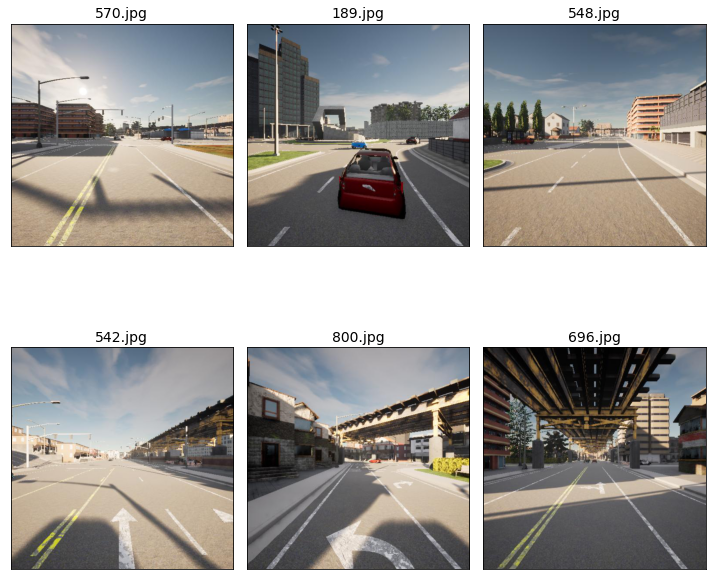

In [ ]:
show_images_from_folder(img_dir=test_data_dir, images=test_images[:6])

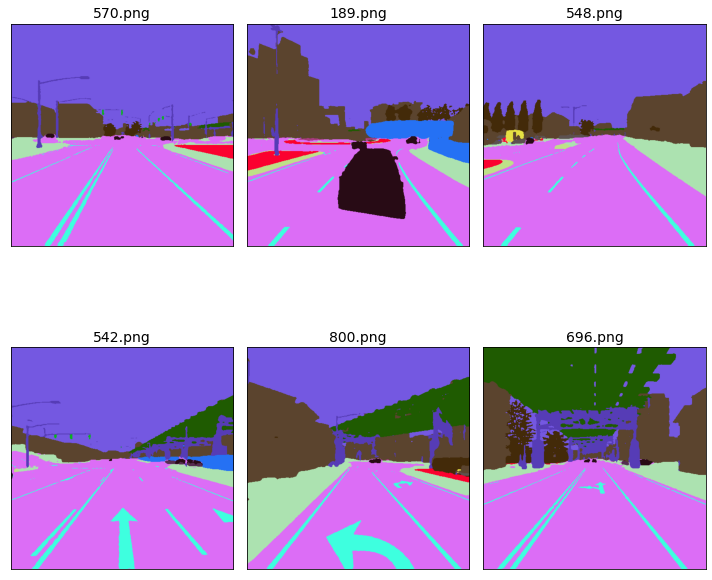

In [ ]:
show_images_from_folder(img_dir="./test_prediction", images= [f"{img_file.split('.')[0]}.png" for img_file in test_images[:6]])